In [2]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import Refraction
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# dont modify this cell unless you know what ya doin'
def createR(sensors,posg):
    data = pg.DataContainer()
    data.registerSensorIndex('s')
    data.registerSensorIndex('g')
    if isinstance(sensors, np.ndarray):
        for x in sensors:
            data.createSensor([x, 0.0, 0.0])
    else:
        data.setSensorPositions(sensors)
    dsC=data.sensorCount()
    #dsC=29
    S, G = [], []
    for s in posg:
        for g in range(dsC):
           if s is not g:
               S.append(s)
               G.append(g)
    data.resize(len(S))
    data.set('s', S)
    data.set('g', G)
    data.set('valid', np.abs(np.sign(data('g') - data('s'))))
    return data

<IPython.core.display.Javascript object>


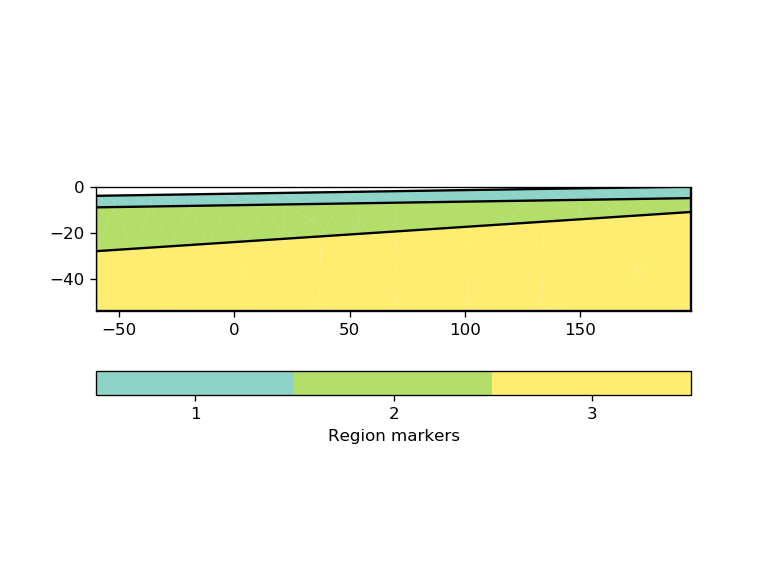

(<matplotlib.axes._subplots.AxesSubplot at 0x7f086605ad68>, None)

In [49]:
# define four vertices for each layer:
layer1 = mt.createPolygon([[-60.0, -4],[198, 0],[198, -5],[-60.0, -9]],isClosed=True, marker=1)
layer2 = mt.createPolygon([[-60.0, -28], [-60.0, -9], [198, -5], [198, -11]],isClosed=True, marker=2)
layer3 = mt.createPolygon([[-60.0, -54], [-60.0, -28], [198, -11], [198, -54]],isClosed=True, marker=3)
slope_surf = 4 / (198+60)
geom = mt.mergePLC([layer1, layer2, layer3])
mesh = mt.createMesh(geom, quality=10, area=0.5, smooth=[10, 10])#,paraMaxCellSize=1.0)
pg.show(geom)

In [32]:
# define array and geophone positions:
numberGeophones = 24
geophones = np.linspace(0., 138, numberGeophones)# equally spaced geophones
gmove=[3,135]# special positions for end shots
geophones=np.append(geophones,gmove)
shots = np.asarray([-60.0,0.0,33,69,105,138,198])
sg=(np.append(geophones,shots))
sg=np.unique(sg)
sg=np.sort(sg);
posg=[]
for i in range(0,len(sg)-1):
    for j in shots:
        if j == sg[i] and j != sg[i+1]:
            posg.append(i)
for j in shots:
    if j == sg[-1:] and j != sg[-2:-1]:
        posg.append(len(sg)-1)
print(posg,"indexing of geophone re python")
print([i+1 for i in posg[:]], "actual position of geophones in list")

[0, 1, 8, 15, 22, 29, 30] indexing of geophone re python
[1, 2, 9, 16, 23, 30, 31] actual position of geophones in list


In [33]:
#scheme_sg=createDataContainer(sg,posg)
scheme_sg=createR(sg,posg)

# Adapt sensor positions to slope
pos = np.array(scheme_sg.sensorPositions())
for x in pos[:, 0]:
    i = np.where(pos[:, 0] == x)
    new_y = -4 + x * slope_surf
    pos[i, 1] = new_y

scheme_sg.setSensorPositions(pos)

<IPython.core.display.Javascript object>


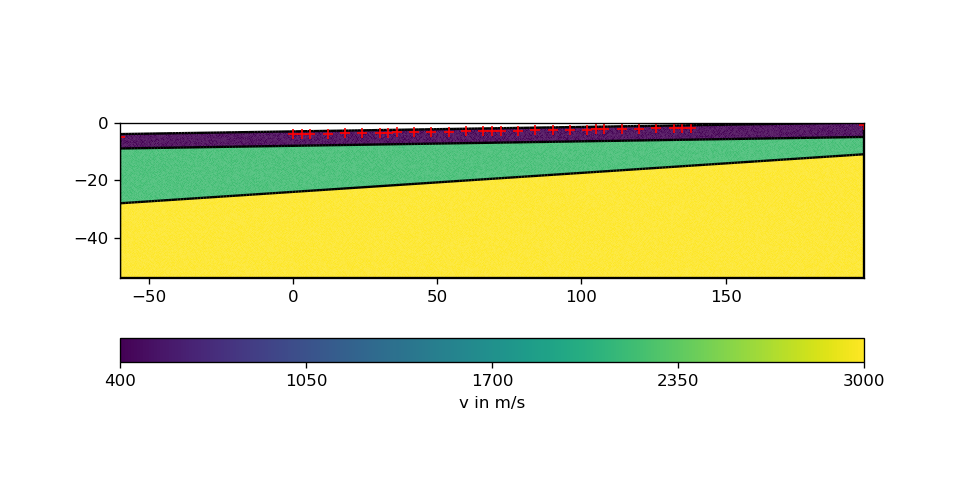

In [48]:
ra = Refraction()
vp = np.array(mesh.cellMarkers())
vp[vp == 1] = 400
vp[vp == 2] = 2200
vp[vp == 3] = 3000

ax, _ = pg.show(mesh, vp,colorBar=True, logScale=False, label='v in m/s')
ax.plot(pos[:, 0], pos[:, 1], 'r+')
fig=plt.gcf();
fig.set_size_inches(8,4)

In [50]:
data = ra.simulate(mesh, 1.0 / vp, scheme_sg, noiseLevel=1e-6, noiseAbs=1e-6,verbose=True)

Data error estimates (min:max)  7.355292090708236e-06 : 0.00011417450712325496


Data: Sensors: 31 data: 210


<IPython.core.display.Javascript object>


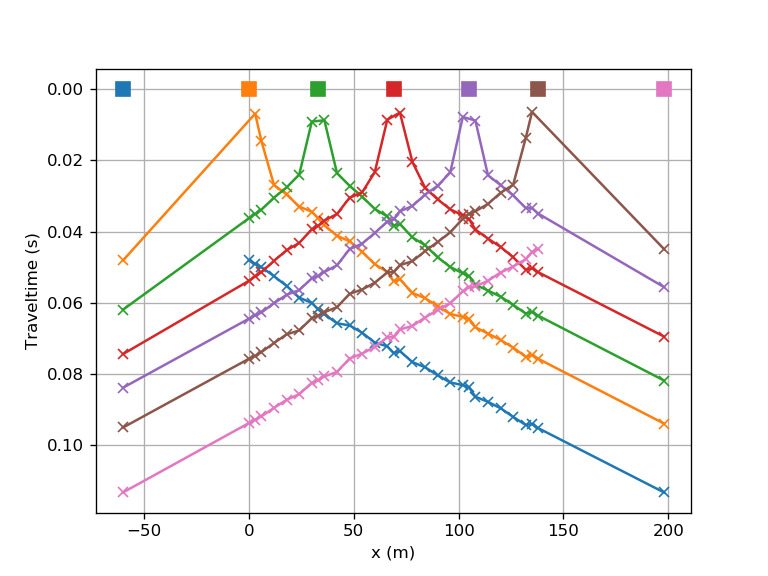

In [51]:
ra = Refraction(data)
ra.showData()

In [58]:
ra.createMesh(depth=54., paraMaxCellSize=5.0, secNodes=1)
# ra.fop.createJacobian(np.ones(ra.fop.regionManager().parameterCount()))
# exit()
vest = ra.invert(zWeight=0.75,maxIter=5)#,depth=60)  

<IPython.core.display.Javascript object>


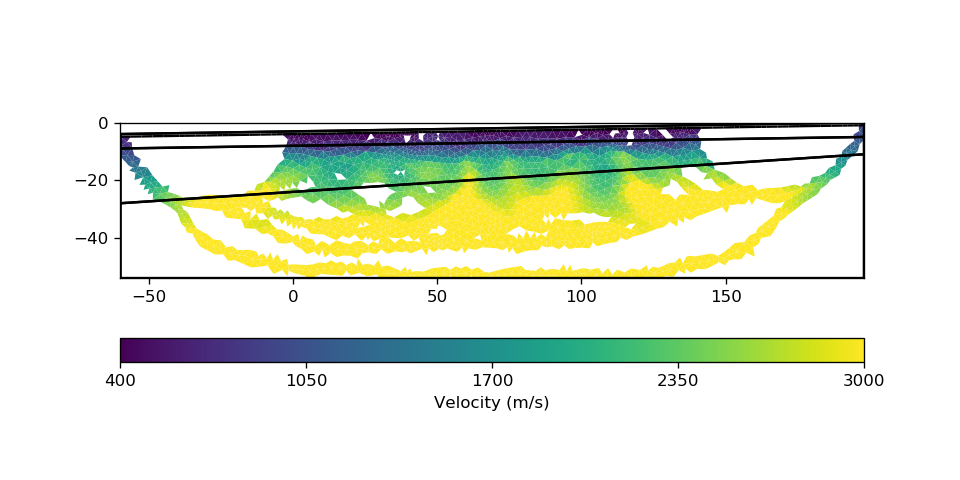

In [59]:
ax, cb = ra.showResult(cMin=min(vp), cMax=max(vp), logScale=False, color='blue')
pg.show(geom, ax=ax, fillRegion=False, regionMarker=False)  # lines on top
fig=plt.gcf();
fig.set_size_inches(8,4)
#ax.get_lines()[0:0].set_color("blue")

<IPython.core.display.Javascript object>


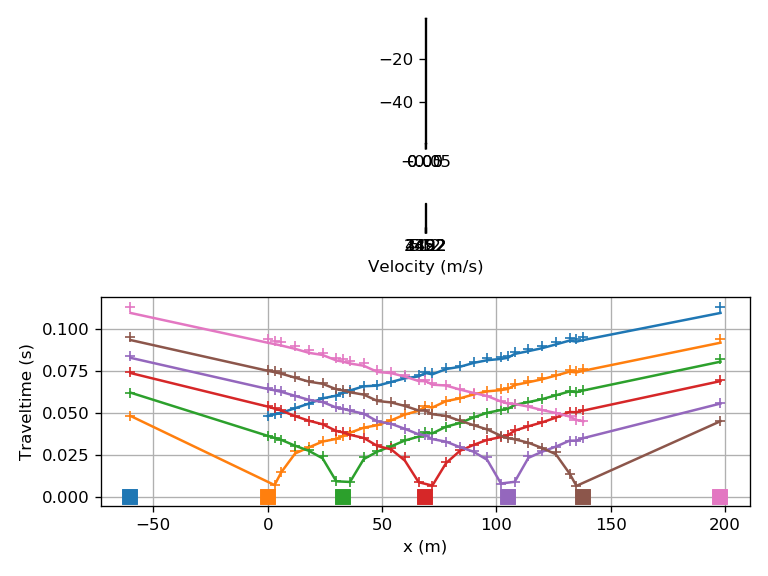

/home/stefan/anaconda3/envs/mypgenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


In [116]:
#ax, _ = pg.show(mesh, vp, colorBar=True, logScale=False, label='v in m/s')
ra.showResultAndFit(plotmisfit=False,colorbar=False)
fig=plt.gcf();
fig.axes[0].set_xlim(0,0);#fig.axes[0].set_xlim(0,1)
plt.tight_layout()


<IPython.core.display.Javascript object>


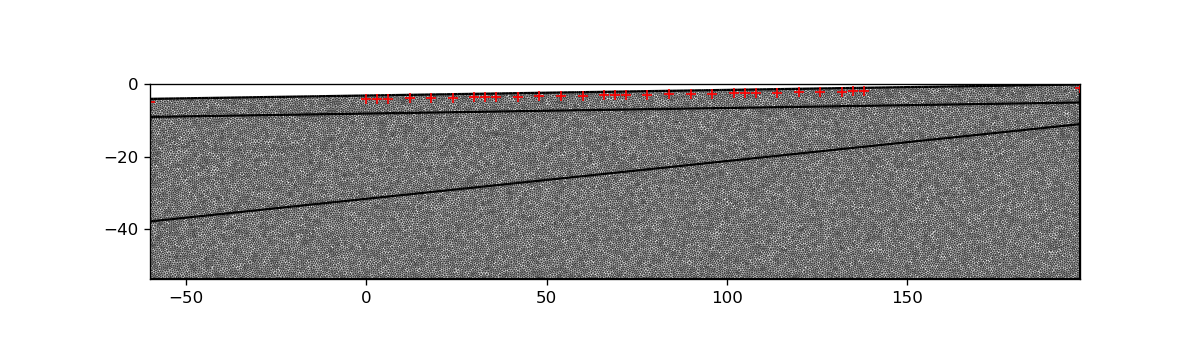

In [54]:
pg.show(mesh);ax=plt.gca();fig=plt.gcf();
fig.set_size_inches(10,3)
ax.plot(pos[:,0],pos[:,1],'r+')
#ax.set_ylim(108,170)
#ax.set_xlim(-2,120)